In [1]:
import utils.data as data
import utils.sub_architectures as sub_architectures
import utils.architectures as architectures
from utils.basic_function import draw_labels
import importlib
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = data.MultiViewTemporalDataset(mode = "validation", preprocess_image_options = {
            "use_mask": True,
            "equalize_hist": False,
            "crop_black": False,
            "match_histogram": False
        }, data_path="data")

In [3]:
autoencoder = sub_architectures.ConvolutionalAutoencoderV2()
state_dict = torch.load("saved_models/ConvolutionalAutoencoderV2/no_histogram_128_trained")
autoencoder.load_state_dict(state_dict)

<All keys matched successfully>

In [34]:
importlib.reload(architectures)
approach1 = architectures.BasicAutoencoderAnomalyDetectionV1(autoencoder, device="cpu", image_sizes=(1024,1024))
#approach2 = architectures.BasicTimestepAnomalyDetection()

approach = architectures.ScoreEnsembleAnomalyDetection([approach1], [1])

In [35]:
samples = [dataset[2]]
sample = samples[0]

Processing sample data/validation/valid-1-2...
Using Autoencoder... 


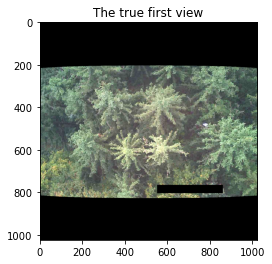

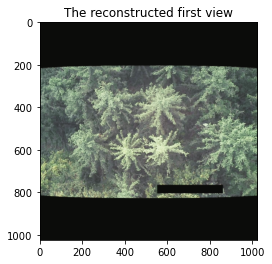

Autoencoder finished. took 17.47s.


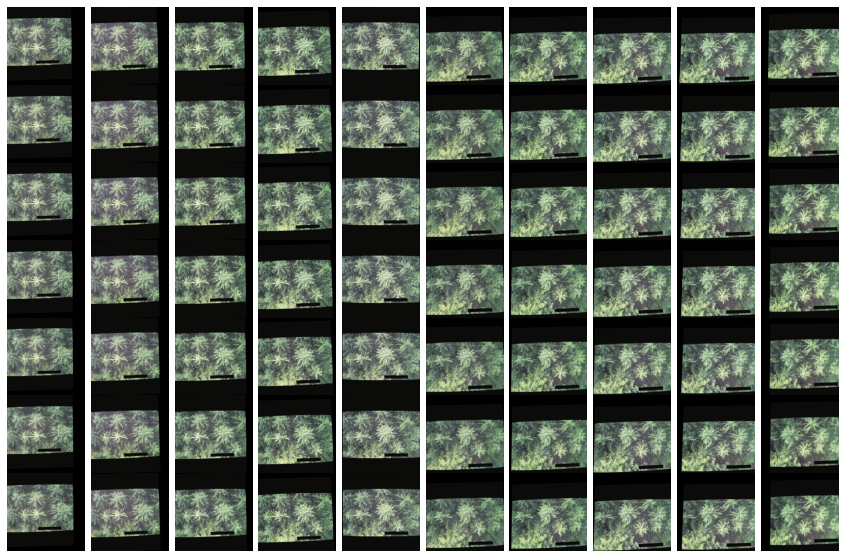

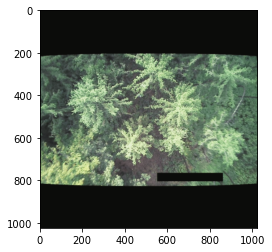

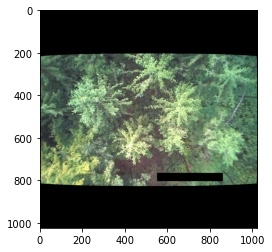

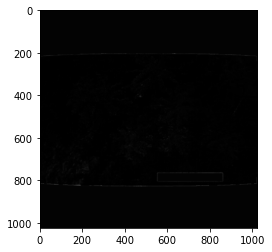

Warping...
Warping finished. Took 3.15s.


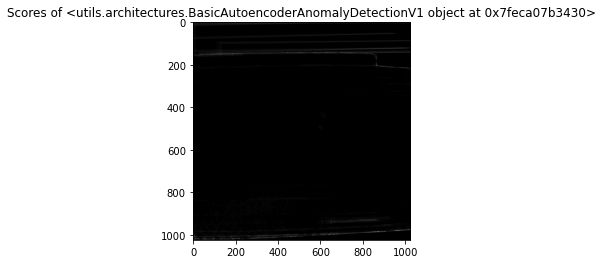

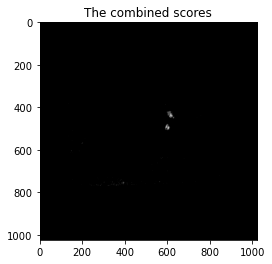

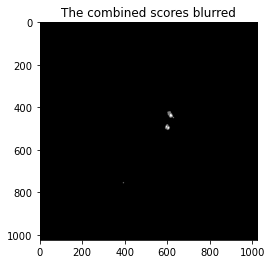

In [31]:
res = approach.infer(samples, verbose=3, threshold=0.1)

In [11]:
res

[array([[499, 558,  27,  27],
        [499, 558,  27,  27]])]

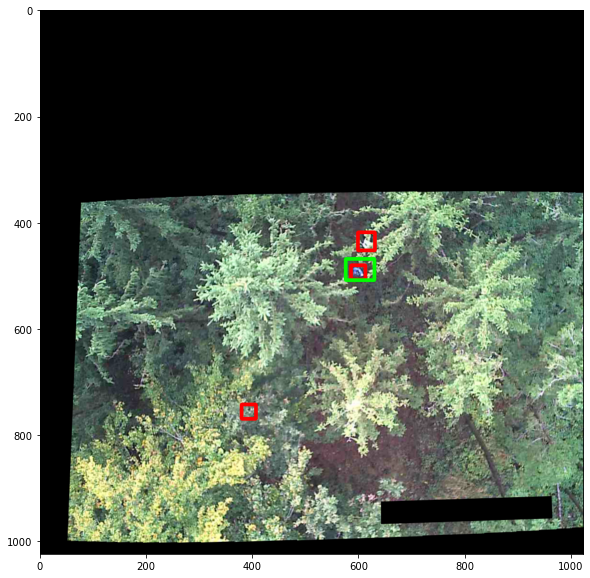

In [32]:
mid_img = sample.get_warped_photo(3,8)
_ = draw_labels(mid_img, [res[0], sample.labels])

Sample Nr. 0:


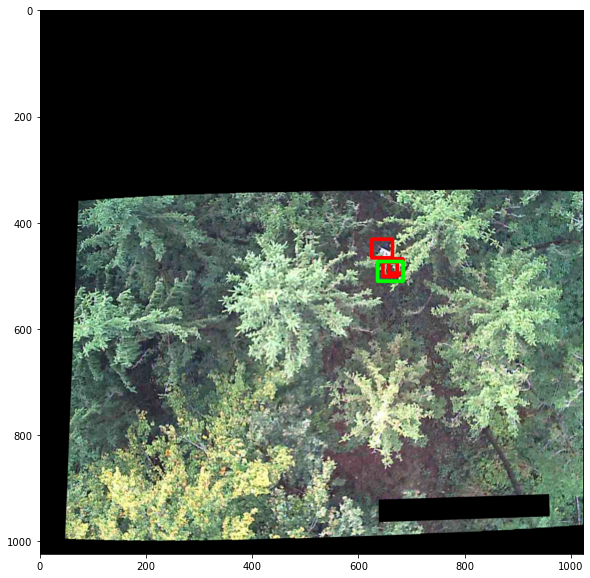

Sample Nr. 1:


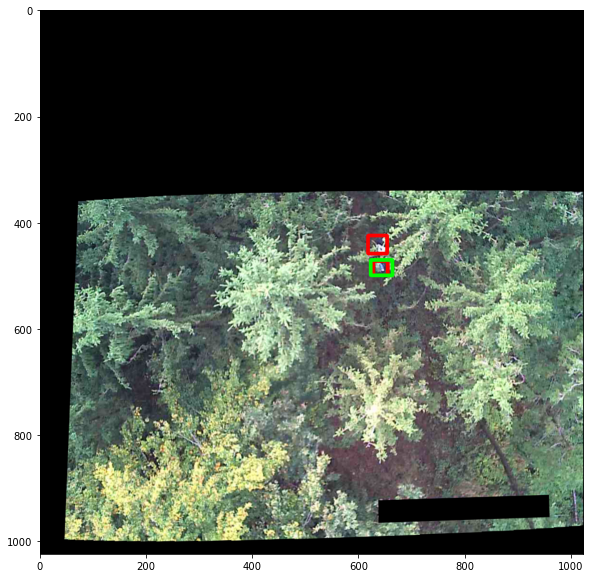

Sample Nr. 2:


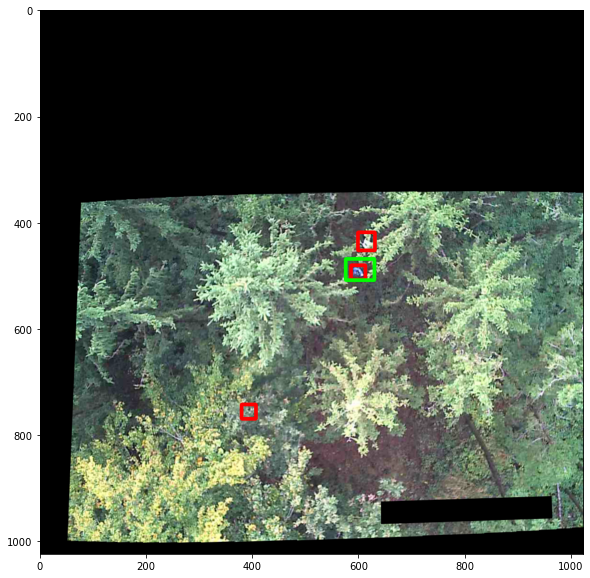

Sample Nr. 3:


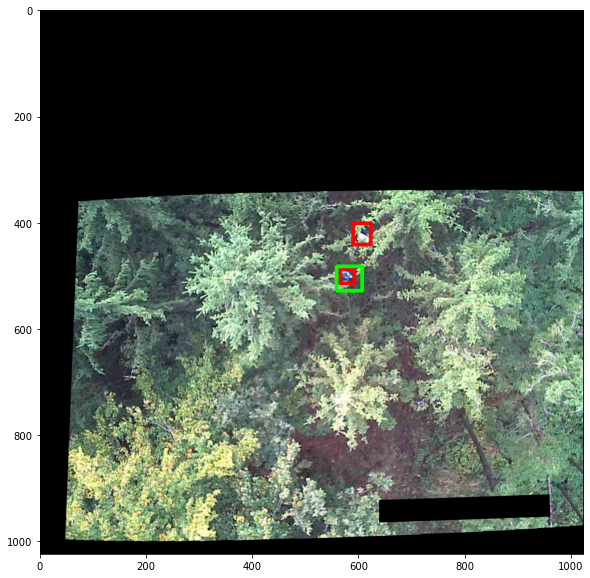

Sample Nr. 4:


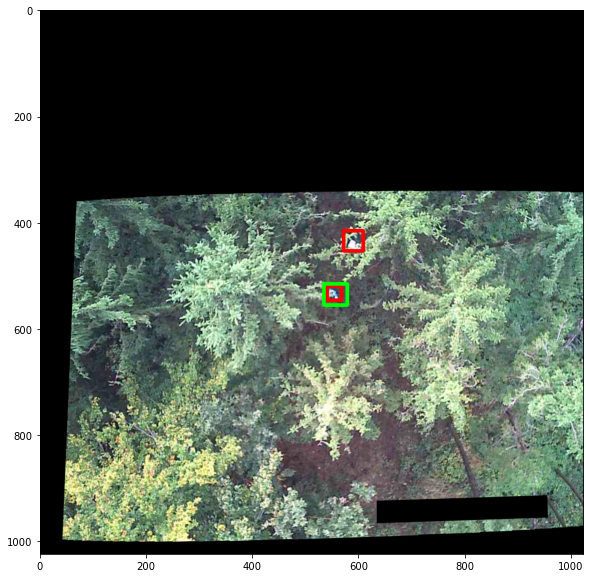

Sample Nr. 5:


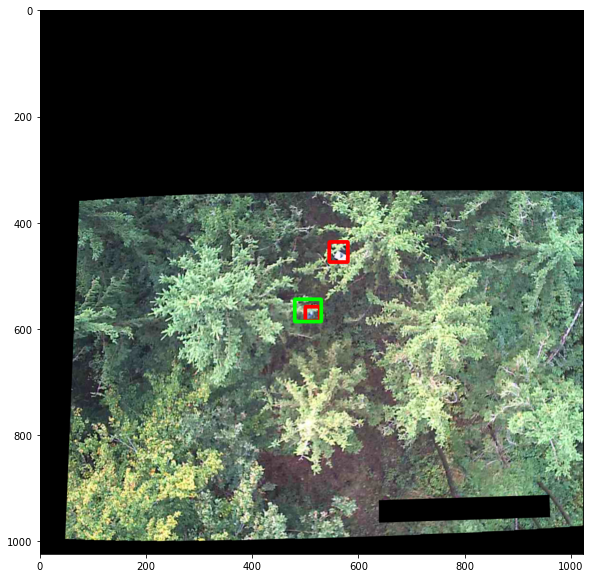

Sample Nr. 6:


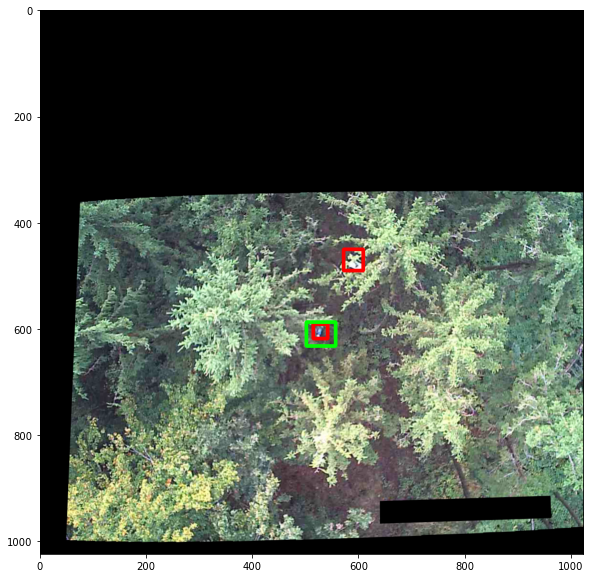

Sample Nr. 7:


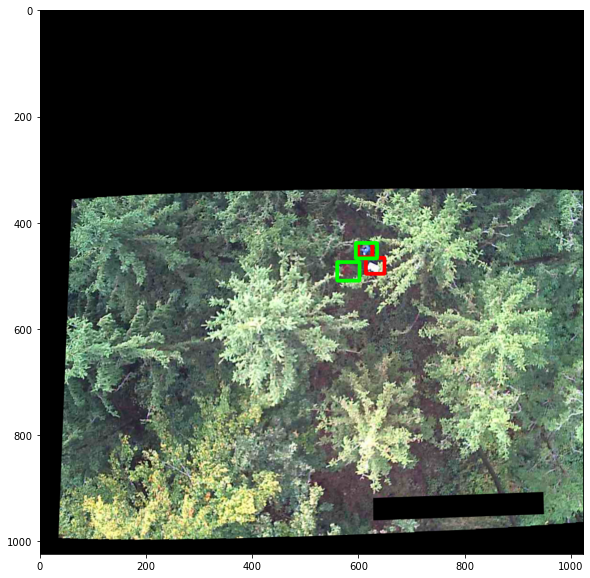

Sample Nr. 8:


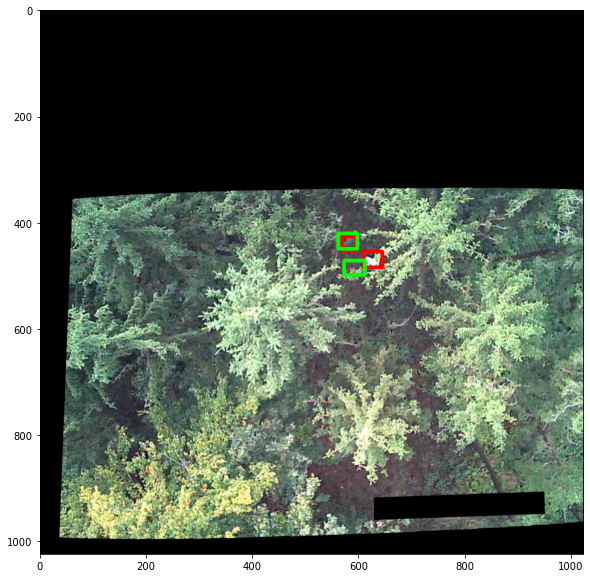

Sample Nr. 9:


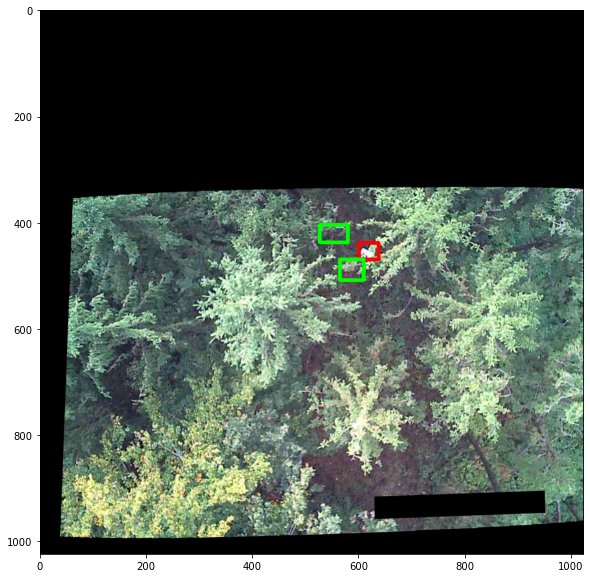

Sample Nr. 10:


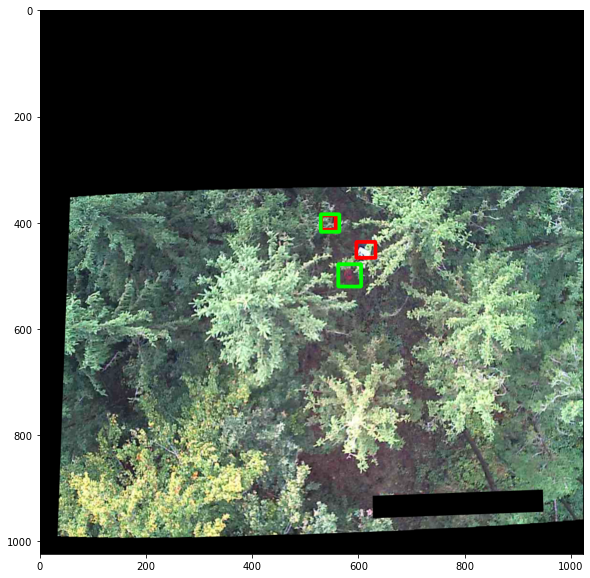

In [36]:
for i in range(len(dataset)):
    print(f"Sample Nr. {i}:")
    sample = dataset[i]
    samples = [sample]

    res = approach.infer(samples, verbose=0, threshold=0.1)

    mid_img = sample.get_warped_photo(3,8)
    draw_labels(mid_img, [res[0], sample.labels])

In [16]:
box_predictions = approach.infer(dataset, threshold=0.1)

In [24]:
box_list = [el.tolist() for el in box_predictions]

In [25]:
import os

box_dict = {}
for sample, boxes in zip(dataset, box_list):
    sample_name = os.path.split(sample.sample_path)[-1]
    box_dict[sample_name] = boxes

In [29]:
import json
with open("predictions.json", "w") as fi:
    json.dump(box_dict, fi)

# Code (Dirty)

In [ ]:
import numpy as np
import torch
from utils.basic_function import integrate_images
import matplotlib.pyplot as plt

In [10]:
sample = dataset[0]
cutoff_value = 0.8

photos = sample.photos
reconstructed_photos = np.empty_like(photos)

# Step 1: Select grid from all images
# Step 2: Put each grid-image into the autoencoder that is passed
# Step 3: Put the reconstructed images back together (to the original time-view-structure)
# Done here:
for timestep_idx, timestep in enumerate(photos):
    for view_idx, view in enumerate(timestep):
        grid_images = []
        reconstructed_view = np.empty_like(view)
        for row in range(16):
            for col in range(16):
                grid_images.append(
                    view[
                        row * 64 : (row + 1) * 64, col * 64 : (col + 1) * 64
                    ]
                )

        grid_images = np.array(grid_images)
        grid_images = (
            np.transpose(grid_images, (0, 3, 1, 2)).astype(np.float32) / 255
        )

        grid_images = torch.tensor(grid_images, device="cpu")
        reconstructed_grid_images = (
            autoencoder(grid_images)
            .detach().cpu()
            .numpy()
        )
        reconstructed_grid_images = np.transpose(
            (reconstructed_grid_images * 255).astype(np.int16), (0, 2, 3, 1)
        )

        i = 0
        for row in range(16):
            for col in range(16):
                reconstructed_view[
                    row * 64 : (row + 1) * 64, col * 64 : (col + 1) * 64
                ] = reconstructed_grid_images[i]
                i += 1
        reconstructed_photos[timestep_idx, view_idx] = reconstructed_view

In [26]:

differences = abs(photos - reconstructed_photos)

integrated = []
for timestep_differences, homographie in zip(
    differences, sample.homographies
):
    integrated.append(
        integrate_images(timestep_differences, homographie, sample.mask)
    )

integrated = np.array(integrated).astype(np.float32)/255

squared_integrated = np.square(integrated)
resulting_integrated = np.mean(squared_integrated, axis=0)

In [35]:
max_res_box = None
values = []
max_value = 0
for i in range(250):
    for e in range(250):
        value = np.mean(resulting_integrated[i * 4: (i+6)*4, e * 4: (e+6)*4])
        values.append(value)
        if value > max_value:
            max_res_box = np.array([i*4, e*4, 6*4, 6*4])
            max_value = value

(array([40459.,  1328.,   928.,   922.,  1716.,  5109.,  7945.,  3232.,
          765.,    96.]),
 array([0.        , 0.03999619, 0.07999238, 0.11998858, 0.15998477,
        0.19998096, 0.23997715, 0.27997333, 0.31996953, 0.35996574,
        0.39996192], dtype=float32),
 <BarContainer object of 10 artists>)

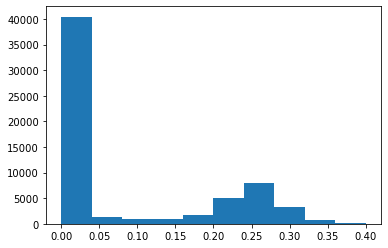

In [32]:
plt.hist(values, bins=10)

In [38]:
max_res_box

array([408, 828,  24,  24])

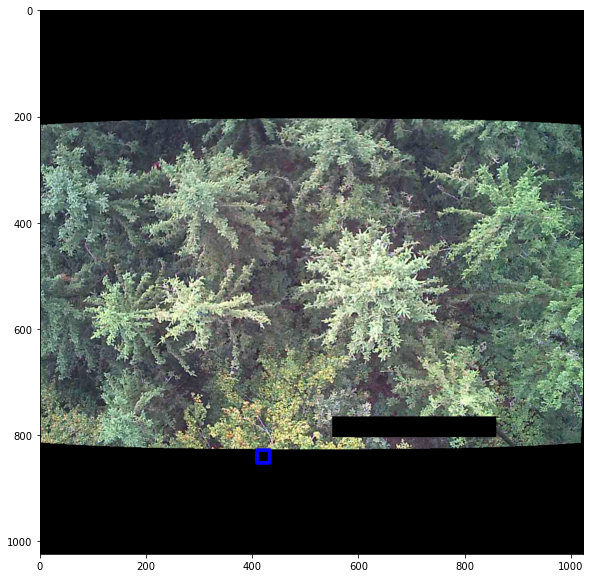

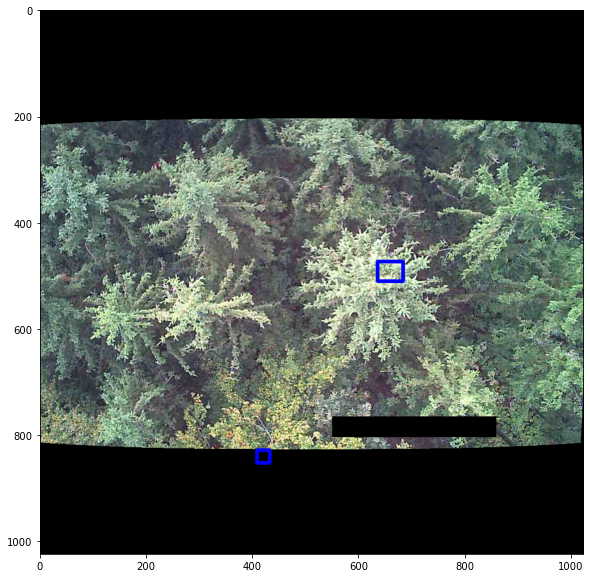

In [44]:
sample.draw_labels(np.array([max_res_box]))
sample.draw_labels()

(array([70870222.,  7850952.,  4940446.,  6853305.,  4158207.,  5590711.,
         3292518.,  4321325.,  2493618.,  3229231.,  2666274.,  1509780.,
         1944162.,  1109481.,  1422327.,   813592.,  1049579.,   612408.,
          793467.,   471716.,   625035.,   537195.,   328129.,   444452.,
          273147.,   393665.,   249593.,   362103.,   237264.,   354175.,
          344242.,   234192.,   338523.,   217182.,   353466.,   243996.,
          378400.,   252401.,   383211.,   277517.,   436868.,   468902.,
          345140.,   538506.,   384910.,   662239.,   470838.,   709617.,
          564489.,   850639.,   926977.,   685131.,  1021608.,   721231.,
         1155692.,   745663.,  1156195.,   783186.,  1247304.,   807069.,
         1140869.,  1016481.,  1593913.,   669359.,   403456.,  1516186.,
          277099.,  1279804.,   196875.,   223511.,   195688.,   122374.,
          168930.,   117502.,   201569.,   152418.,   268177.,   212495.,
          378398.,   300349.,   536419

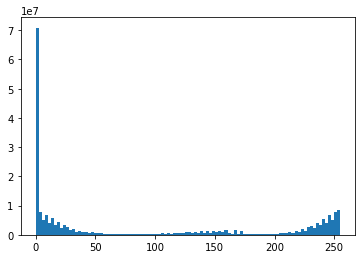

In [25]:
plt.hist(differences.reshape(-1), bins=100)